In [2]:
import numpy as np
import scipy
from scipy.linalg import expm
import random
import math
from scipy.stats import unitary_group
import matplotlib.pyplot as plt
from scipy.optimize import minimize, curve_fit, basinhopping, differential_evolution
import matplotlib

In [ ]:
def split_array(arr, index):
    return [arr[:index], arr[index:]]

data = []
for ch in range(4):
    for H in range(3):
        with open(f"Calibration Example_915\ch{ch + 1}_H{H + 1}.txt") as file:
            for line in file:
                try:
                    row = [float(num) for num in line.split()]
                    data.append([H, ch] + row)
                except:
                    pass

def create_un_mat(v):
    Mc = np.zeros((4, 4), dtype=np.complex128)
    Mc[0][1] = v[0] + 1j * v[1]
    Mc[1][0] = v[0] - 1j * v[1]
    
    Mc[0][2] = v[2] + 1j * v[3]
    Mc[2][0] = v[2] - 1j * v[3]
    
    Mc[0][3] = v[4] + 1j * v[5]
    Mc[3][0] = v[4] - 1j * v[5]

    Mc[1][2] = v[6] + 1j * v[7]
    Mc[2][1] = v[6] - 1j * v[7]

    Mc[1][3] = v[8] + 1j * v[9]
    Mc[3][1] = v[8] - 1j * v[9]

    Mc[2][3] = v[10] + 1j * v[11]
    Mc[3][2] = v[10] - 1j * v[11]
    
    U = expm(1j * Mc)
    
    return U



def f(v, data):
    M1 = create_un_mat(v[:12])
    M2 = create_un_mat(v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[0]] = 10**(-5) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[1]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost


def f_nd(v, data=data):
    # global data
    M1 = create_un_mat(v[:12])
    M2 = create_un_mat(v[12:24])
    alpha = np.reshape(v[24:33], (3, 3))
    h_0 = v[33:36]
    cost = 0
    for i in data:
        x = np.zeros(3)
        x[i[0]] = 10**(-5) * i[2] ** 2
        y = i[3:]
        y /= np.sum(y)
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        predict = (np.abs(np.transpose(M2.dot(H).dot(M1)))** 2)[i[1]]
        cost += np.linalg.norm(np.array(predict) - y)
    return cost


def numerical_gradient(data, x, epsilon=1e-8):
    grad = np.zeros_like(x)
    f_0 = f(x, data)
    for i in range(len(x)):
        x_up = np.copy(x)
        x_down = np.copy(x)
        x_up[i] += epsilon
        x_down[i] -= epsilon
        grad[i] = (f_0 - f(x_down, data)) / (2 * epsilon)
    return np.sign(grad)




def gradient_descent(data, x0, learning_rate_start=0.01, learning_rate_finish=0.002, max_iter=1000, tol=1e-4):
    x = np.array(x0, dtype=float)
    dt_vec = np.ones(len(x0)) * learning_rate_start
    for i in range(max_iter):
        dt_vec = np.clip(dt_vec, 0, learning_rate_start)
        f0 = f(x, data)
        for j in range(len(x0)):
            x[j] += dt_vec[j]
            f_up = f(x, data)
            x[j] -= 2 * dt_vec[j]
            f_down = f(x, data)
            if f_up < f0:
                x[j] += 2 * dt_vec[j]
            elif f_down > f0:
                x[j] += dt_vec[j]
                dt_vec[j] *= 0.8
            dt_vec[j] *= 1.03
        if i % 10 == 0:
            print(x)
            print("Iteration = ", i)
            print(f(x, data))
            print(dt_vec)
    return x, f(x, data)

def gradient_descent_nd(data, x0, learning_rate_start=0.01, learning_rate_finish=0.002, max_iter=1000, tol=1e-4):
    x = np.array(x0, dtype=float)
    dt_vec = np.ones(len(x0)) * learning_rate_start
    for i in range(max_iter):
        dt_vec = np.clip(dt_vec, 0, learning_rate_start)
        f0 = f_nd(x, data)
        for j in range(len(x0)):
            x[j] += dt_vec[j]
            f_up = f_nd(x, data)
            x[j] -= 2 * dt_vec[j]
            f_down = f_nd(x, data)
            if f_up < f0:
                x[j] += 2 * dt_vec[j]
            elif f_down > f0:
                x[j] += dt_vec[j]
                dt_vec[j] *= 0.8
            dt_vec[j] *= 1.03
        if i % 10 == 0:
            print(x)
            print("Iteration = ", i)
            print(f_nd(x, data))
            print(dt_vec)
    return x, f(x, data)

In [6]:
# Define parameter bounds for each dimension
dim = 36  # Number of parameters
bounds = [(-2, 2)] * dim  # Typical bounds for Rastrigin

# Run differential evolution to find a global minimum
result = differential_evolution(f_nd, bounds, strategy='best1bin', updating='immediate')

# Extract global initial guess
initial_guess = result.x
initial_loss = result.fun

# Output
print("🌍 Best initial guess found:")
print("Parameters:", initial_guess)
print("Function value:", initial_loss)


🌍 Best initial guess found:
Parameters: [ 1.91326242  0.33811433 -1.14337995  0.52333614 -0.38834714  0.14744523
 -0.85982948  0.52825861 -1.85198004  1.99372634  1.14918155  1.73866765
 -0.94870659 -1.72996879  0.49429135  0.84307355  1.23083485  0.02569966
  0.82089312 -0.99859878 -1.65020273 -0.3302756   1.2956594  -0.11375081
  0.89047027  0.5254506  -0.85310995 -1.29379862  1.18014743 -0.67299028
  1.08573217  0.37724368 -0.60296156  0.16611889  0.08975488 -0.14965396]
Function value: 372.85051910768857


In [24]:
print(data)

[[0, 0, 0.001, 0.1698698, 0.1178782, 0.08086818, 0.1031569], [0, 0, 0.002, 0.1699058, 0.1177419, 0.08073036, 0.1031422], [0, 0, 0.003, 0.1700044, 0.1176096, 0.08093975, 0.1031839], [0, 0, 0.004, 0.1702695, 0.1173505, 0.0806434, 0.1031864], [0, 0, 0.005, 0.1702981, 0.1174765, 0.08051741, 0.1033853], [0, 0, 0.006, 0.1706756, 0.1177261, 0.08045234, 0.1036652], [0, 0, 0.007, 0.170665, 0.1174234, 0.08043874, 0.1034073], [0, 0, 0.008, 0.170736, 0.1170502, 0.08047364, 0.1035915], [0, 0, 0.009, 0.1707095, 0.1167902, 0.08013707, 0.1039353], [0, 0, 0.01, 0.1712258, 0.1167213, 0.08010571, 0.1038493], [0, 0, 0.011, 0.1713997, 0.1168632, 0.07977919, 0.1040556], [0, 0, 0.012, 0.1718397, 0.1162902, 0.07942724, 0.1056073], [0, 0, 0.013, 0.1716722, 0.1163948, 0.07937992, 0.1055484], [0, 0, 0.014, 0.1722363, 0.1161848, 0.07895403, 0.105875], [0, 0, 0.015, 0.1726, 0.1158457, 0.07878309, 0.1063955], [0, 0, 0.016, 0.1734672, 0.1157007, 0.07860148, 0.1064446], [0, 0, 0.017, 0.1736199, 0.1151389, 0.07810698,

In [ ]:
# x0 = [-0.41787547, -0.18504808,  0.44831782, -0.9248506 ,  0.4016049 , -0.24746775,
#  -0.04578627,  1.3592343 , -0.67259892,  0.83798169,  0.37996106,  0.25830816,
#   0.12016575,  1.94091927,  0.92471875,  0.4298926 ,  0.78182305,  1.48576622,
#   0.28119859,  0.90557274,  0.28573387,  0.93179326,  1.37962862,  0.32020062,
#   2.44455675, -0.21100629,  0.28743759, -0.17984061,  0.03300196,  0.89548313,
#   0.12244837,  0.63345639,  0.23770722, -0.26129656,  0.40731544, -1.36835074]
x0 = minimum_x_iter

result_minimize = basinhopping(f_nd, x0, niter = 2)
# result_minimize = minimize(f_nd, x0)

print(result_minimize.fun)
# print(create_un_mat(x0[0:12]))

424.11466074259283
The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


In [8]:
print(result_minimize.x)
print(f_nd(result_minimize.x))
# print(len(data))
# minimum_x = result.x

[ 0.33404767 -0.08644383  1.40990753  1.52557069  0.84292937  1.21304814
  1.6327745   0.17137872  1.27585288  0.5133342   1.90109675  0.56607767
 -0.12901737  0.65069972  1.71074277 -0.16214063  2.16215101  1.72988655
  1.49233782  1.27448833  1.15172446 -0.30343256  1.98851228  1.28533331
  2.22672703  2.42630675  1.43799669  1.8521244   1.57087535  2.04183551
  2.06941281  1.87200668  2.22347026  3.73530888  1.10474666  3.19556277]
424.11466074259283
1572


In [ ]:
minimum_f_iter = 1000
minimum_x_iter = np.ones(36)
for i in range(100):
    x0=np.random.random(36)
    minimum_x, minimum_f = gradient_descent_nd(data, x0, learning_rate_start=0.05, learning_rate_finish=0.002, max_iter=50)
    if minimum_f<minimum_f_iter:
        minimum_f_iter = minimum_f
        minimum_x_iter = minimum_x

print(f"Минимум функции: f({minimum_x}) = {minimum_f}")

In [5]:
minimum_f_iter

441.5542925455634

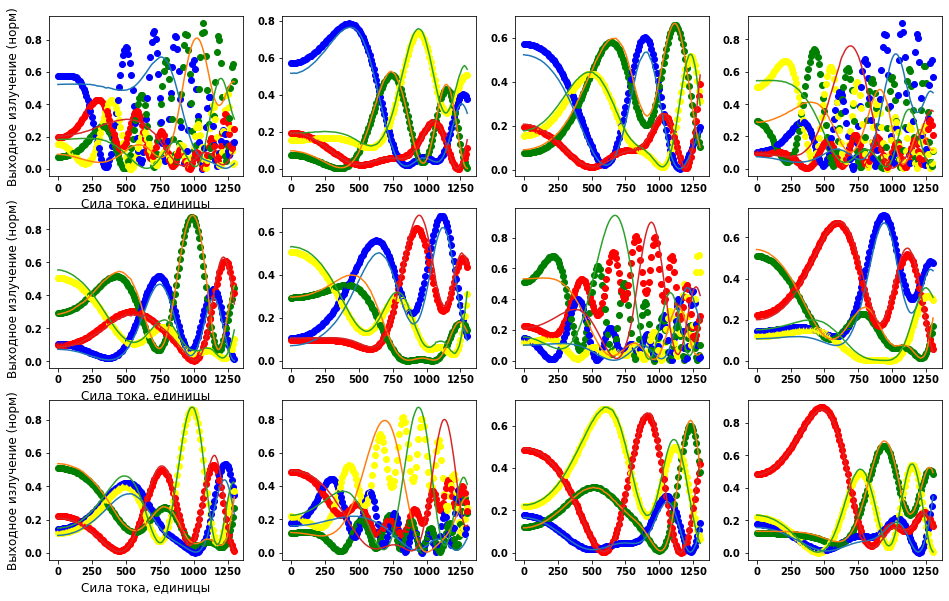

In [ ]:
# params = result_minimize.x
params = [-0.41787547, -0.18504808,  0.44831782, -0.9248506 ,  0.4016049 , -0.24746775,
 -0.04578627,  1.3592343 , -0.67259892,  0.83798169,  0.37996106,  0.25830816,
  0.12016575,  1.94091927,  0.92471875,  0.4298926 ,  0.78182305,  1.48576622,
  0.28119859,  0.90557274,  0.28573387,  0.93179326,  1.37962862,  0.32020062,
  2.44455675, -0.21100629,  0.28743759, -0.17984061,  0.03300196,  0.89548313,
  0.12244837,  0.63345639,  0.23770722, -0.26129656,  0.40731544, -1.36835074]

M1 = create_un_mat(params[:12])
M2 = create_un_mat(params[12:24])
alpha = np.reshape(params[24:33], (3, 3))
h_0 = params[33:36]

fig, ax = plt.subplots(3, 4, figsize=(16, 10))

for j in range(12):

    for i in data[131*j:131*(j+1)]:
        x = np.zeros(3)
        x[i[0]] = 10**(-5)*i[2] ** 2
        h_list = h_0 + alpha.dot(np.transpose(x))
        H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        result = (np.abs(np.transpose(M2.dot(H).dot(M1))) ** 2)[i[1]]
        ax[j//4][j%ax[j//4][j%4].scatter(i[2], result[1], color = 'green')
        ax[j//4][j%4].scatter(i[2], result[2], color = 'yellow')
        ax[j//4][j%4].scatter(i[2], result[3], color = 'red')4].scatter(i[2], result[0], color = 'blue')
        

    ax[j//4][j%4].plot([d[2] for d in data[131*j:131*(j+1)]], [d[3]/sum(d[3:]) for d in data[131*j:131*(j+1)]])#, color = 'blue')
    ax[j//4][j%4].plot([d[2] for d in data[131*j:131*(j+1)]], [d[4]/sum(d[3:]) for d in data[131*j:131*(j+1)]])#, color = 'green')
    ax[j//4][j%4].plot([d[2] for d in data[131*j:131*(j+1)]], [d[5]/sum(d[3:]) for d in data[131*j:131*(j+1)]])#, color = 'yellow')
    ax[j//4][j%4].plot([d[2] for d in data[131*j:131*(j+1)]], [d[6]/sum(d[3:]) for d in data[131*j:131*(j+1)]])#, color = 'red')

    ax[j//4][0].set_xlabel('Сила тока, единицы', fontsize=12)
    ax[j//4][0].set_ylabel('Выходное излучение (норм)', fontsize=12)

    # fig.suptitle('Фитирование данных Ильи с помощью нашего кода')

   
plt.show()



In [22]:
data[0]

[0, 0, 0.001, 0.02492056, 0.01872662, 0.02171225, 0.04885687]

In [54]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

matplotlib.rc('axes', titlesize=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

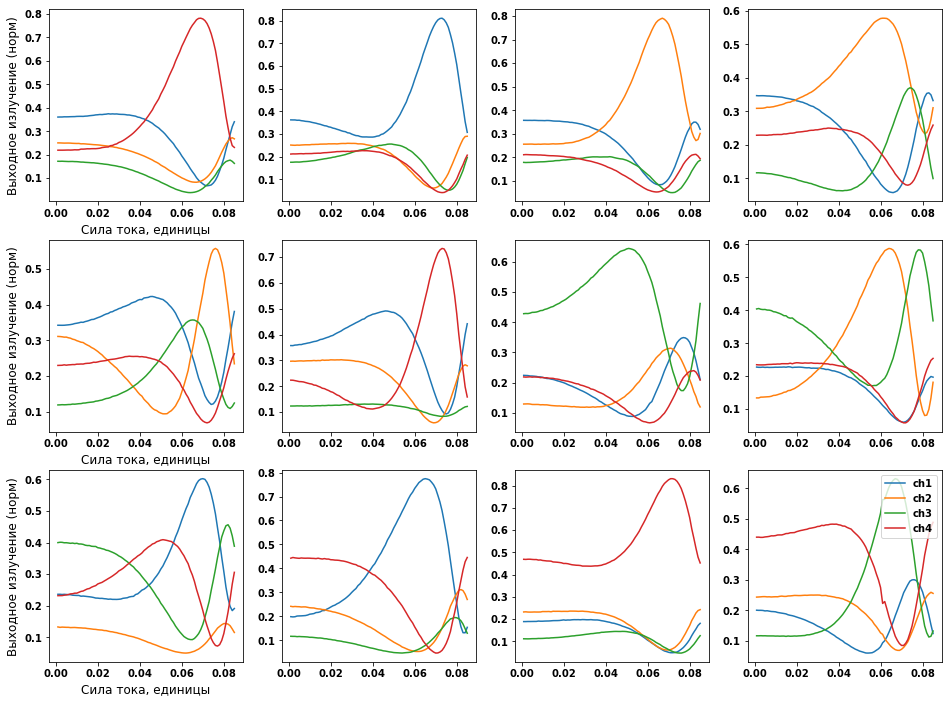

In [ ]:
# params = result_minimize.x
params = [-0.41787547, -0.18504808,  0.44831782, -0.9248506 ,  0.4016049 , -0.24746775,
 -0.04578627,  1.3592343 , -0.67259892,  0.83798169,  0.37996106,  0.25830816,
  0.12016575,  1.94091927,  0.92471875,  0.4298926 ,  0.78182305,  1.48576622,
  0.28119859,  0.90557274,  0.28573387,  0.93179326,  1.37962862,  0.32020062,
  2.44455675, -0.21100629,  0.28743759, -0.17984061,  0.03300196,  0.89548313,
  0.12244837,  0.63345639,  0.23770722, -0.26129656,  0.40731544, -1.36835074]

M1 = create_un_mat(params[:12])
M2 = create_un_mat(params[12:24])
alpha = np.reshape(params[24:33], (3, 3))
h_0 = params[33:36]

fig, ax = plt.subplots(3, 4, figsize=(16, 12))


for j in range(12):

    # for i in data[131*j:131*(j+1)]:
        # x = np.zeros(3)
        # x[i[0]] = 10**(-5)*i[2] ** 2
        # h_list = h_0 + alpha.dot(np.transpose(x))
        # H = np.diag([math.e ** (1j * h) for h in h_list] + [1])
        # result = (np.abs(np.transpose(M2.dot(H).dot(M1))) ** 2)[i[1]]
        # ax[j//4][j%4].scatter(i[2], result[0], color = 'blue')
        # ax[j//4][j%4].scatter(i[2], result[1], color = 'green')
        # ax[j//4][j%4].scatter(i[2], result[2], color = 'yellow')
        # ax[j//4][j%4].scatter(i[2], result[3], color = 'red')

    ax[j//4][j%4].plot([d[2] for d in data[85*j:85*(j+1)]], [d[3]/sum(d[3:]) for d in data[85*j:85*(j+1)]], label='ch1')#, color = 'blue')
    ax[j//4][j%4].plot([d[2] for d in data[85*j:85*(j+1)]], [d[4]/sum(d[3:]) for d in data[85*j:85*(j+1)]], label='ch2')#, color = 'green')
    ax[j//4][j%4].plot([d[2] for d in data[85*j:85*(j+1)]], [d[5]/sum(d[3:]) for d in data[85*j:85*(j+1)]], label='ch3')#, color = 'yellow')
    ax[j//4][j%4].plot([d[2] for d in data[85*j:85*(j+1)]], [d[6]/sum(d[3:]) for d in data[85*j:85*(j+1)]], label='ch4')#, color = 'red')

    ax[j//4][0].set_xlabel('Сила тока, единицы', fontsize=12)
    ax[j//4][0].set_ylabel('Выходное излучение (норм)', fontsize=12)
    plt.legend()

    # fig.suptitle('Фитирование данных Ильи с помощью нашего кода')

   
plt.show()